

## Random thoughts and notes (disregard)

Separate model for outliers 

Removing time dependency, depending on the test data and how it will look like

Will there be nan in test?

Treating each stock separately? 
Treating clusters of stocsk?

Far and near prices are not available 5 minutes prior. Should we split models based on this?


When training, remove date_id 

Be careful when using the next day data, we have to have no lookeahead bias in the real competition

per stock model?
regimes - volatile day? 3 regimes based on the auction dynamics

Changing the error to squared to penalize precision


# Loading Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
#set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

Due to the size of dataset, we can load all integral features into bytes (int 8) and short (int 16). We can also try to load float features into float 32 or float 16 if we want. You have to keep in mind that this sacrifices the accuracy of our calculation though.

In [7]:
dtypes = {
    'stock_id' : np.uint8,
    'date_id' : np.uint16,
    'seconds_in_bucket' : np.uint16,
    'imbalance_buy_sell_flag' : np.int8,
    'time_id' : np.uint16,
}
path = "C:\\Users\\lukab\\Desktop\\Optiver\\"
train = pd.read_csv(path + 'train.csv', dtype = dtypes).drop(['row_id'], axis = 1)
test = pd.read_csv('test.csv', dtype = dtypes).drop(['row_id'], axis = 1)

gc.collect()

0

##  1) One day and  one stock dataframe
I focus one one individual day and one stock at first

In [8]:
individual_df = train[(train['date_id'] == 0)&(train['stock_id'] == 0)]
individual_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4


In [9]:
individual_df.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
9550,0,0,500,1158754.78,1,0.999491,26914637.05,1.000241,1.000026,0.999383,52137.93,0.999491,81899.84,0.999425,0.979900,50
9741,0,0,510,1088759.13,1,0.999598,26967180.45,1.000241,1.000241,0.999491,43188.64,0.999598,9329.00,0.999579,0.649691,51
9932,0,0,520,1008684.09,1,0.999598,27047255.49,1.000241,1.000026,0.999383,19493.43,0.999598,78456.89,0.999426,6.779432,52
10123,0,0,530,998138.08,1,0.999491,27075253.75,1.000241,1.000026,0.999383,70978.47,0.999491,35166.56,0.999455,6.140471,53
10314,0,0,540,906957.07,1,0.999383,27183793.68,1.000241,0.999919,0.999276,111912.00,0.999383,9793.35,0.999375,9.759665,54


### a) time_id and seconds_in_bucket

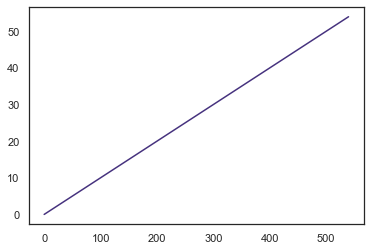

In [10]:
# Checking how time-id and seconds in bucket correspond
plt.plot(individual_df['seconds_in_bucket'],individual_df['time_id'])

In [11]:
for feature in ['time_id','seconds_in_bucket']:
    print('There is max',max(individual_df[feature].value_counts().values),'repetitions of',feature)

There is max 1 repetitions of time_id
There is max 1 repetitions of seconds_in_bucket


In [12]:
feature_diff_dict = {}
feature_max_dict = {}
feature_min_dict = {}
for feature in ['time_id','seconds_in_bucket']:
    feature_diff_dict[feature] = []
    feature_max_dict[feature] = []
    feature_min_dict[feature] = []
    for i in train['stock_id'].unique()[0:25]:
        for j in train['date_id'].unique()[0:25]:
            ind_df = train[(train['stock_id']==i*2)&(train['date_id']==j*50)]
            feature_diff_dict[feature].append(ind_df[feature].max() - ind_df[feature].min()) 
            feature_max_dict[feature].append(ind_df[feature].max() )
            feature_min_dict[feature].append(ind_df[feature].min())

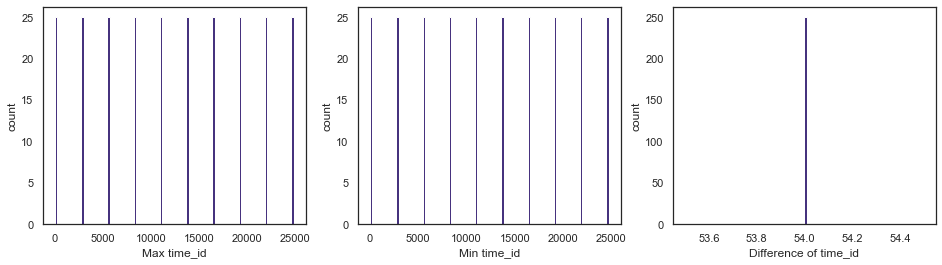

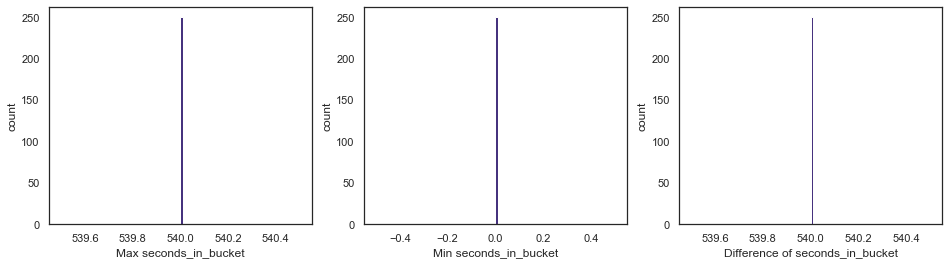

In [13]:
for feature in ['time_id','seconds_in_bucket']:
    plt.figure(figsize=(16,4))
    #plt.title(feature)
    plt.subplot(1,3,1)
    plt.hist(feature_max_dict[feature],bins=100)
    plt.xlabel('Max ' + feature)
    plt.ylabel('count')
    
    plt.subplot(1,3,2)
    plt.hist(feature_min_dict[feature],bins=100)
    plt.xlabel('Min ' + feature)
    plt.ylabel('count')
    plt.subplot(1,3,3)
    
    plt.hist(feature_diff_dict[feature],bins=100)
    plt.xlabel('Difference of ' + feature)
    plt.ylabel('count')

In [14]:
ind_df = train[(train['date_id'] == 1)&(train['stock_id'] == 1)]
ind_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
10506,1,1,0,648832.14,-1,0.999710,2714505.33,NaN,NaN,0.999884,517.35,1.000232,1035.06,1.000000,7.330179,55
10697,1,1,10,576049.80,-1,0.999884,2787287.67,NaN,NaN,0.999826,17244.00,1.000812,17261.00,1.000319,-1.360178,56
10888,1,1,20,527413.26,-1,0.998782,2816090.16,NaN,NaN,0.998782,9129.78,0.999594,35859.20,0.998947,11.500120,57
11079,1,1,30,527413.26,-1,0.998840,2816090.16,NaN,NaN,0.998782,26355.78,0.999536,45338.57,0.999060,14.779568,58
11270,1,1,40,522756.57,-1,0.999420,2820746.85,NaN,NaN,0.999246,1723.40,1.000696,51777.00,0.999293,5.420446,59


In [16]:
ind_df.tail()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
20056,1,1,500,0.00,0,1.000812,5033536.95,1.000812,1.000812,1.000986,15192.32,1.001160,3453.40,1.001127,3.069639,105
20247,1,1,510,23110.98,-1,1.000928,5027672.97,1.000870,1.000928,1.000522,33304.08,1.001218,22793.76,1.000935,6.040335,106
20438,1,1,520,23110.98,-1,1.001160,5027672.97,1.000870,1.001160,1.000638,55053.02,1.001450,2418.08,1.001415,6.029606,107
20629,1,1,530,23110.98,-1,1.001160,5027672.97,1.000870,1.001044,1.000638,85254.52,1.001450,1209.04,1.001438,9.599924,108
20820,1,1,540,60536.97,-1,1.001855,5078896.56,1.001334,1.001797,1.001797,37320.48,1.002203,28174.55,1.002029,-0.550151,109


### Comment #1: 
There are 540 seconds of auction for each day. Each date has 54 * 10 seconds in bucket denoted by the time_id. Our target is shifted by 60 seconds in the future, so this would correspond to the full 10 minutes of auction (540 + 60 = 600 seconds).

# 2) Start time

In [17]:
no_null_min_list = []
no_null_max_list = []
for i in train['stock_id'].unique()[0:100]:
    for j in train['date_id'].unique()[0:100]:
        ind_df = train[(train['stock_id']==i*2)&(train['date_id']==j*50)]
        ind_nonull_df = ind_df.dropna(how='any',axis=0)
        no_null_min_list.append(ind_nonull_df['seconds_in_bucket'].min())
        no_null_max_list.append(ind_nonull_df['seconds_in_bucket'].max())

Text(0.5, 0, 'Minimum seconds in bucket')

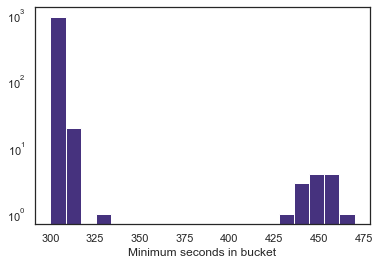

In [18]:
plt.hist(no_null_min_list,bins=20);
plt.yscale('log')
plt.xlabel('Minimum seconds in bucket')

Text(0.5, 0, 'Maximum seconds in bucket')

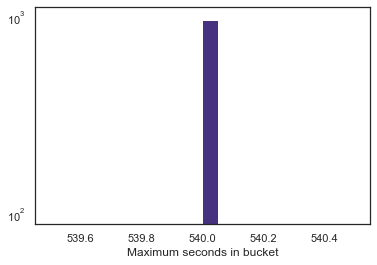

In [19]:
plt.hist(no_null_max_list,bins=20);
plt.yscale('log')
plt.xlabel('Maximum seconds in bucket')

Text(0.5, 1.0, 'Four stocks for 500 days')

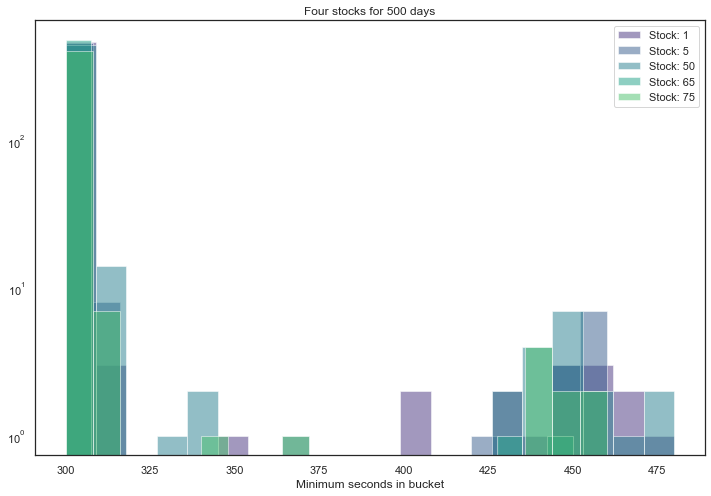

In [20]:
plt.figure(figsize=(12,8))
for i in [1,5,50,65,75]:
    no_null_min_list = []
    no_null_max_list = []
    for j in train['date_id'].unique()[0:500]:
        ind_df = train[(train['stock_id']==i*2)&(train['date_id']==j)]
        ind_nonull_df = ind_df.dropna(how='any',axis=0)
        no_null_min_list.append(ind_nonull_df['seconds_in_bucket'].min())
    plt.hist(no_null_min_list,bins=20,label='Stock: ' + str(i),alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Minimum seconds in bucket')
plt.legend()
plt.title('Four stocks for 500 days')

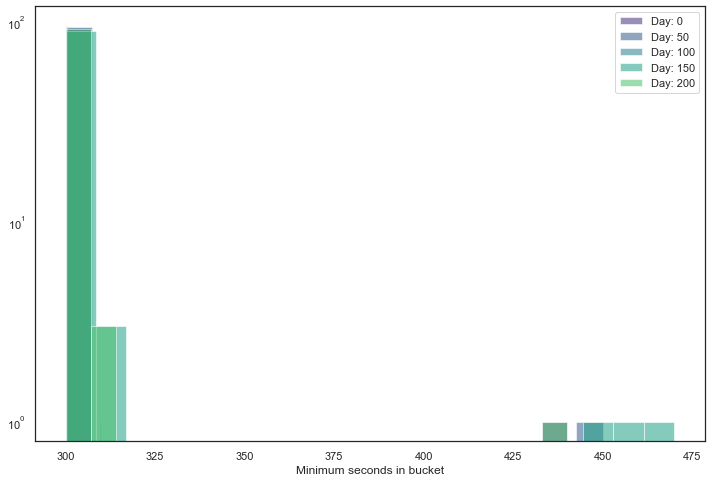

In [21]:
plt.figure(figsize=(12,8))
for j in [i*50 for i in range(0,5)]:
    no_null_min_list = []
    no_null_max_list = []
    for i in train['stock_id'].unique()[0:100]:
        ind_df = train[(train['stock_id']==i*2)&(train['date_id']==j)]
        ind_nonull_df = ind_df.dropna(how='any',axis=0)
        no_null_min_list.append(ind_nonull_df['seconds_in_bucket'].min())
    plt.hist(no_null_min_list,bins=20,label='Day: ' + str(j),alpha=0.55)
    plt.yscale('log')
    plt.xlabel('Minimum seconds in bucket')
plt.legend()

## Comment #2: 
#### Auctions start at different times, but always end at the same time. It is unclear how this different starting time is distributed and if it matters (unpopular vs popular stocks?)


It is unclear to me how the target is obtained right at the start of the auction.
Kaggle information: revealed_targets When the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.

# 3)  Null values

In [22]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T], axis = 1)
desc

,count,nunique,%unique,null,type,count,mean,std,min,25%,50%,75%,max
stock_id,5237980,200,0.003818,0,uint8,5237980.0,9.928856e+01,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,5237980,481,0.009183,0,uint16,5237980.0,2.415100e+02,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,5237980,55,0.001050,0,uint16,5237980.0,2.700000e+02,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,5237760,2971863,56.736815,220,float64,5237760.0,5.715293e+06,2.051591e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,5237980,3,0.000057,0,int8,5237980.0,-1.189619e-02,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,5237760,28741,0.548704,220,float64,5237760.0,9.999955e-01,2.532497e-03,0.935285,9.987630e-01,9.999670e-01,1.001174e+00,1.077488e+00
matched_size,5237760,2948862,56.297695,220,float64,5237760.0,4.510025e+07,1.398413e+08,4316.610000,5.279575e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,2343638,95739,1.827785,2894342,float64,2343638.0,1.001713e+00,7.214705e-01,0.000077,9.963320e-01,9.998830e-01,1.003318e+00,4.379531e+02
near_price,2380800,84625,1.615604,2857180,float64,2380800.0,9.996601e-01,1.216920e-02,0.786988,9.971000e-01,9.998890e-01,1.002590e+00,1.309732e+00
bid_price,5237760,28313,0.540533,220,float64,5237760.0,9.997263e-01,2.499345e-03,0.934915,9.985290e-01,9.997280e-01,1.000905e+00,1.077488e+00


In [23]:
train[train['target'].isnull()].head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929


In [24]:
train[train['wap'].isnull()].head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929


### Comments 3:
Most of the null values for the far and near price are here by design. But, theres 88 missing targets and 220 rows with other type of missing data. 

The missing values specific stocks on specific days. This should be taken into account, espiecally if the test sets has missing values as well.

## 4) Random day and random stocks

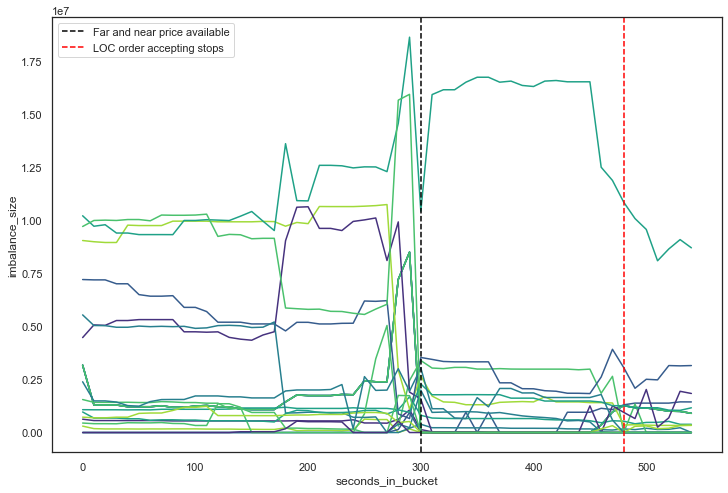

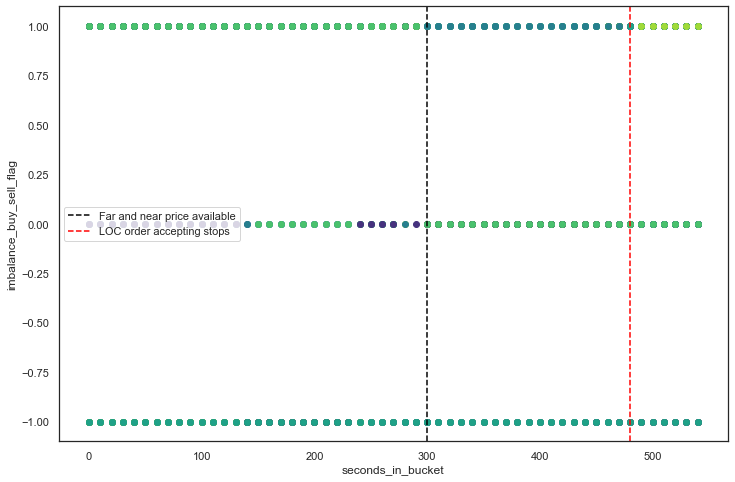

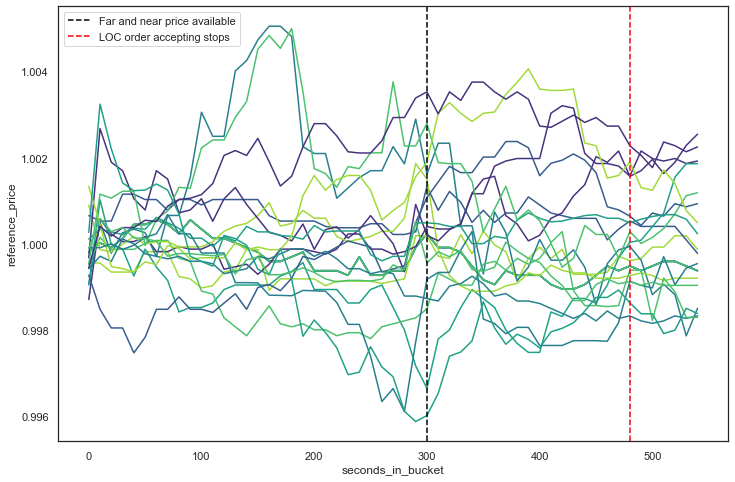

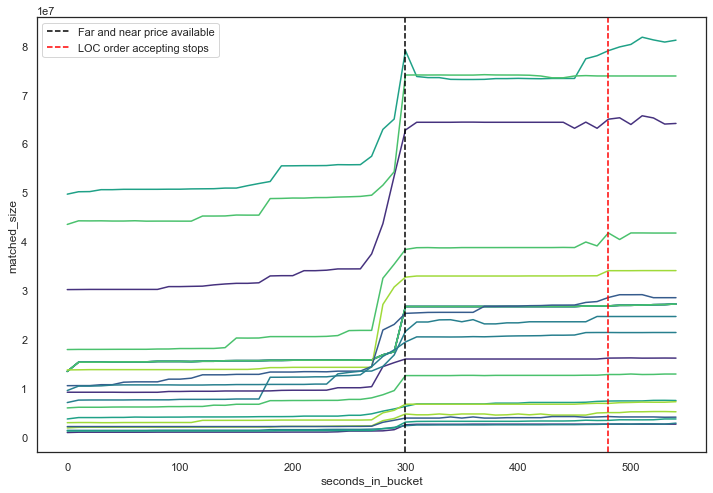

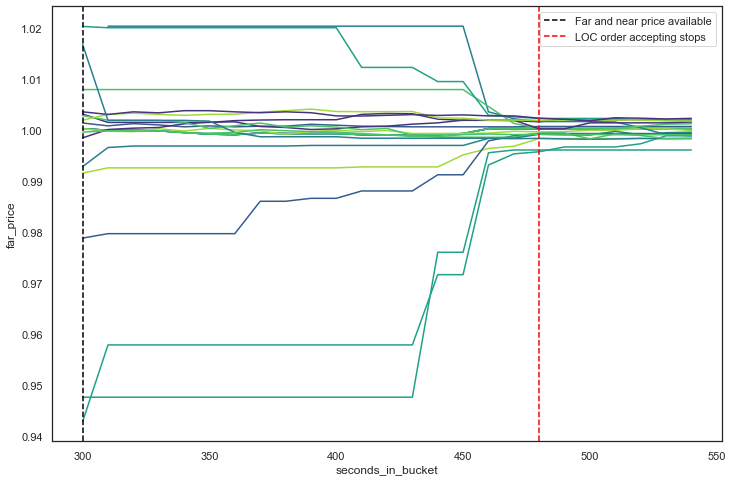

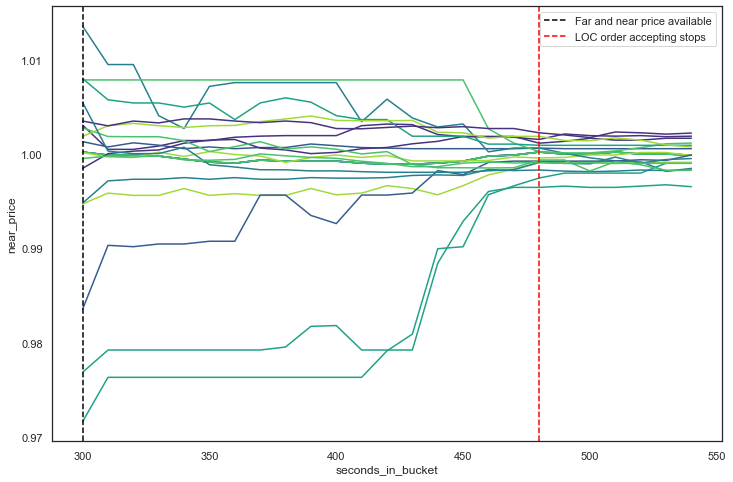

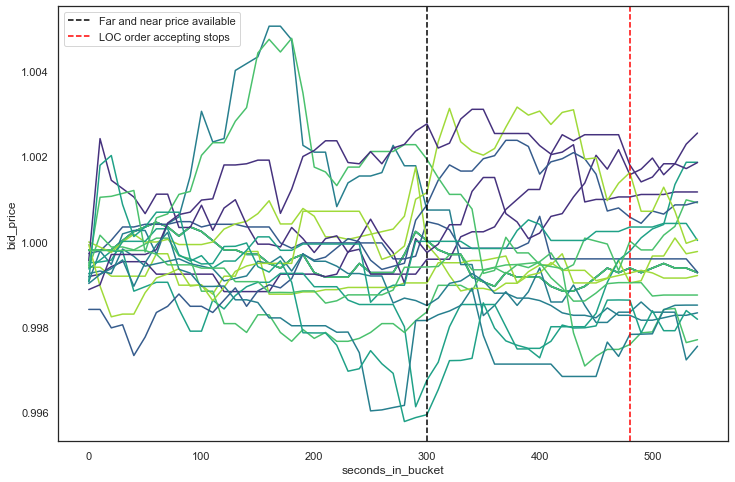

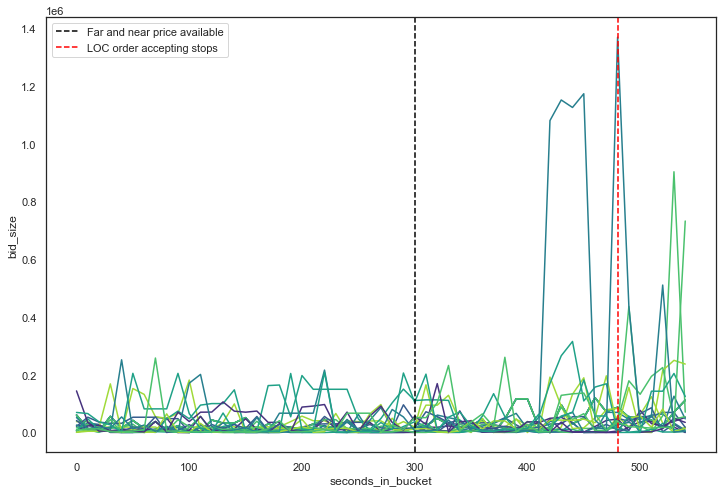

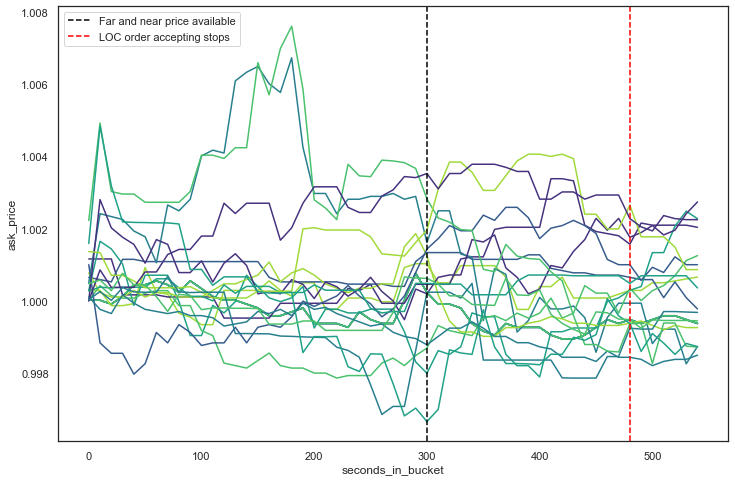

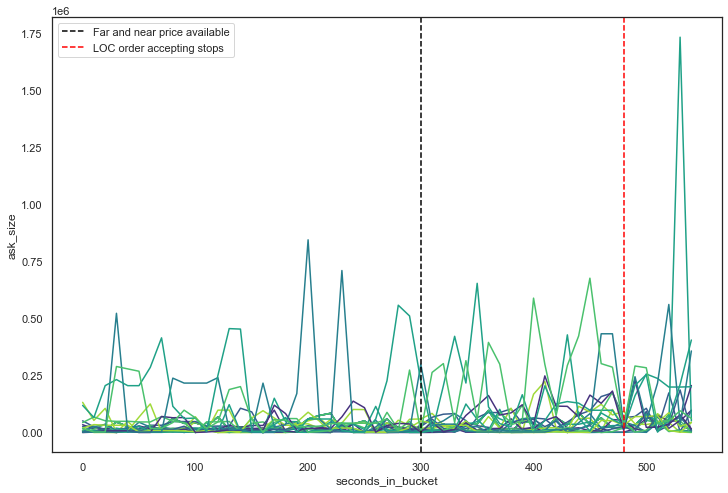

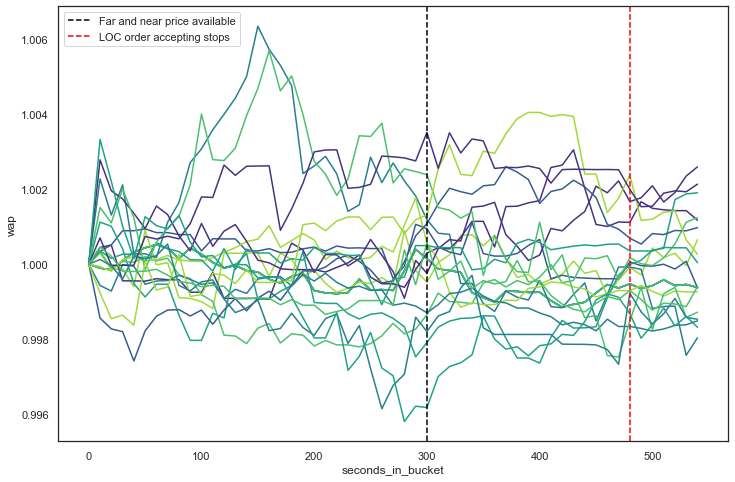

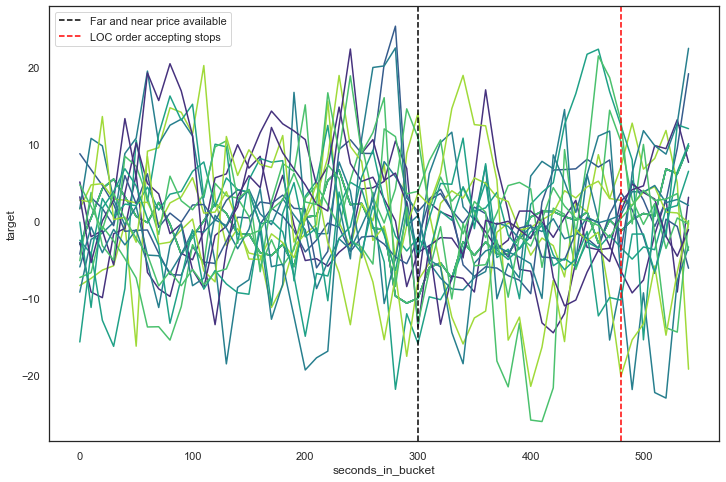

In [25]:
for feature in ind_df.columns[3:-1]:
    plt.figure(figsize=(12,8))
    for  i in train['stock_id'].unique()[0:5]:
        for j in train['date_id'].unique()[0:5]:
            ind_df = train[(train['stock_id']==i*2)&(train['date_id']==i*j*50)]
            if feature =='imbalance_buy_sell_flag':
                plt.scatter(ind_df['seconds_in_bucket'],ind_df[feature])
            else:
                plt.plot(ind_df['seconds_in_bucket'],ind_df[feature])
            plt.xlabel('seconds_in_bucket')
    plt.axvline(300,linestyle='--',color='black',label='Far and near price available')
    plt.axvline(480,linestyle='--',color='red',label='LOC order accepting stops')
    plt.ylabel(feature)
    plt.legend()

## Comment 4:
It seems that there might be three different regimes at play, that correspond to dynamics of the auction process. At 300 seconds 
and at ~480seconds. We might consider splitting the data and training different models based on this as well.

Kaggle: The term far price refers to the hypothetical uncross price of the auction book, if it were to uncross at the reporting time. Nasdaq provides far price information 5 minutes before the closing cross.

The hypothetical uncross price of combined book is called the near price. Nasdaq provides near price information 5 minutes before the closing cross.

# 2 Per day analysis
I group the data by date_id

In [26]:
number_of_rows = {}
number_of_stocks = {}
num_feature_mean_dict = {}
num_feature_std_dict = {}
additional_features_dict = {}
additional_features = ['number_of_rows','number_of_stocks']
numerical_features = ['imbalance_size', 'reference_price', 'matched_size', 'far_price',
       'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap','target']
for date_id in train['date_id'].unique():
    date_df = train[train['date_id'] == date_id]
    number_of_rows[date_id] = len(date_df)
    number_of_stocks[date_id]  = len(date_df['stock_id'].unique())
    additional_features_dict['number_of_rows'] = number_of_rows
    additional_features_dict['number_of_stocks'] = number_of_stocks
for feature in numerical_features:
    print(feature)
    num_feature_mean_dict[feature] = {}
    num_feature_std_dict[feature] = {}
    for date_id in train['date_id'].unique():
        specific_df = train[train['date_id'] == date_id]
        num_feature_mean_dict[feature][date_id] = specific_df[feature].mean()
        num_feature_std_dict[feature][date_id] = specific_df[feature].std()

imbalance_size
reference_price
matched_size
far_price
near_price
bid_price
bid_size
ask_price
ask_size
wap
target


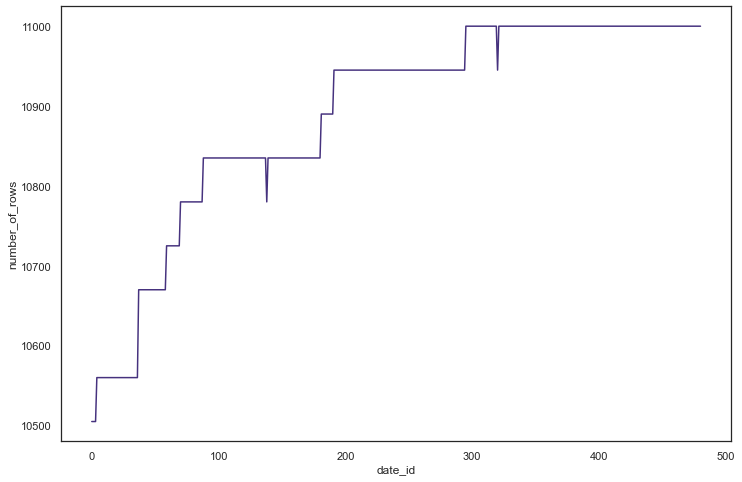

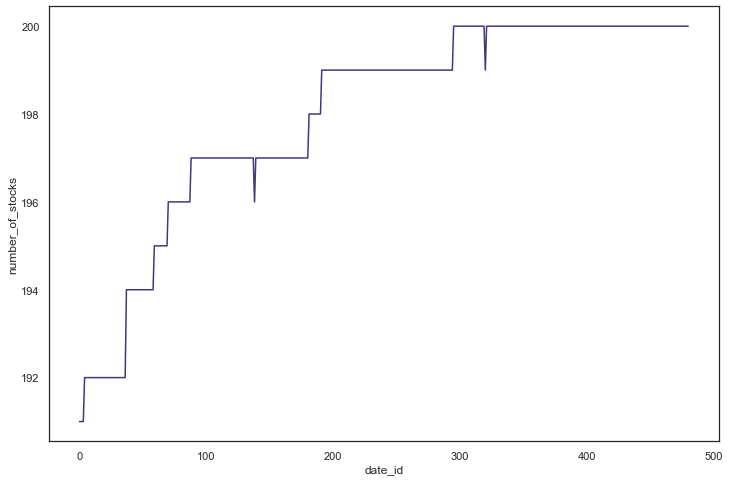

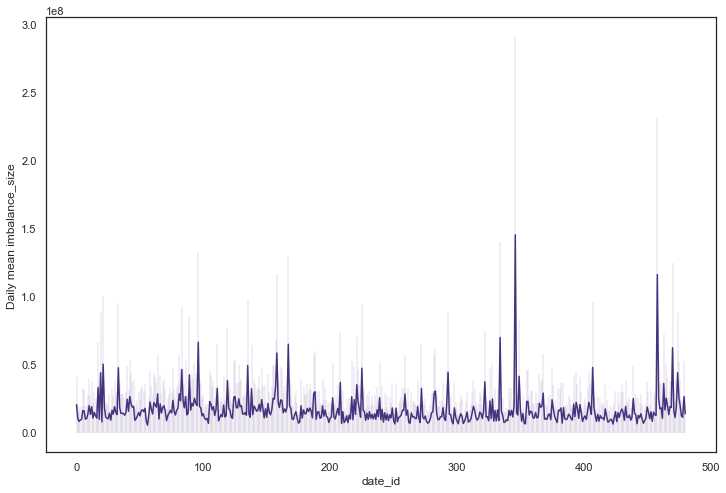

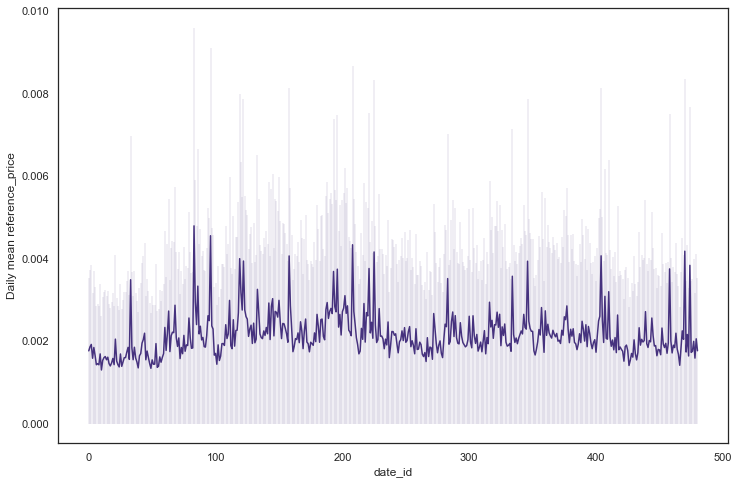

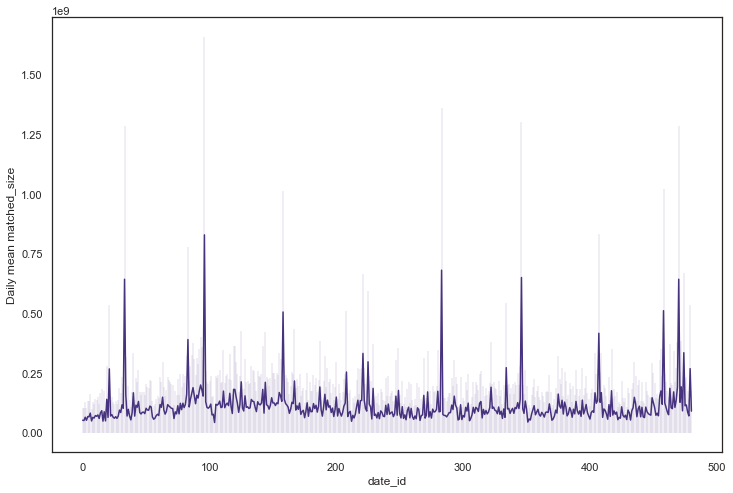

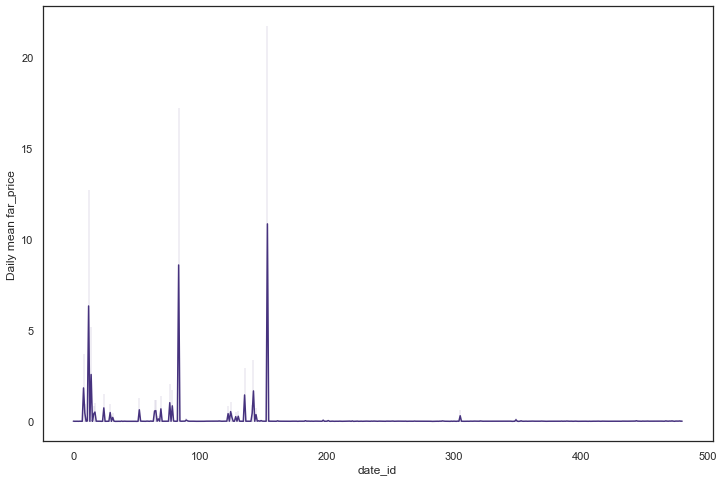

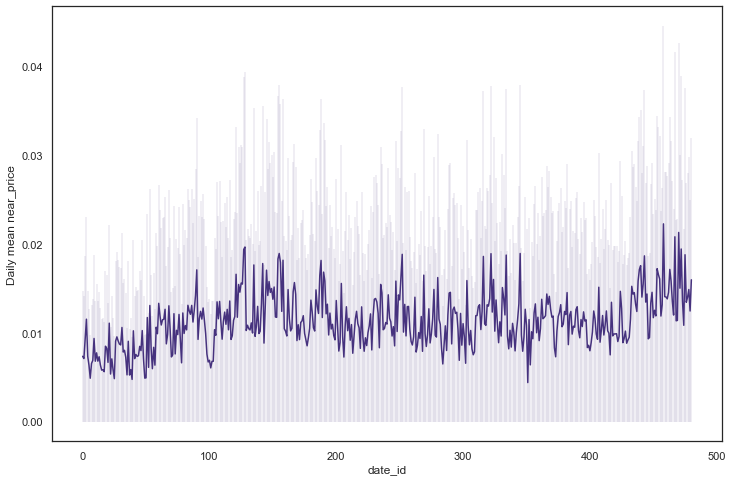

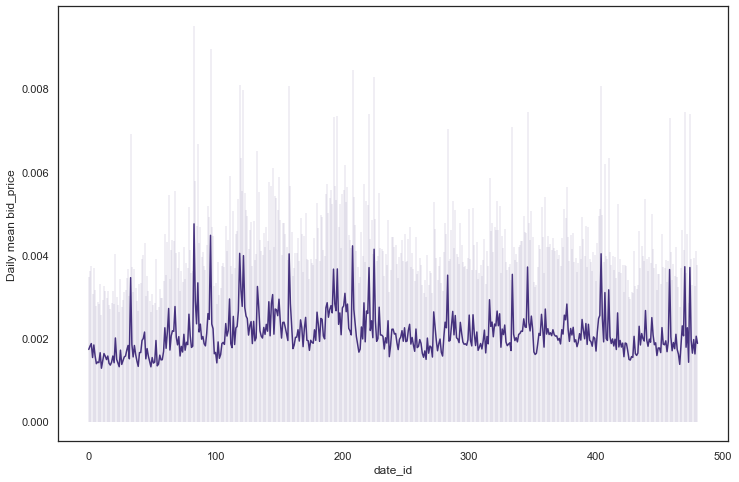

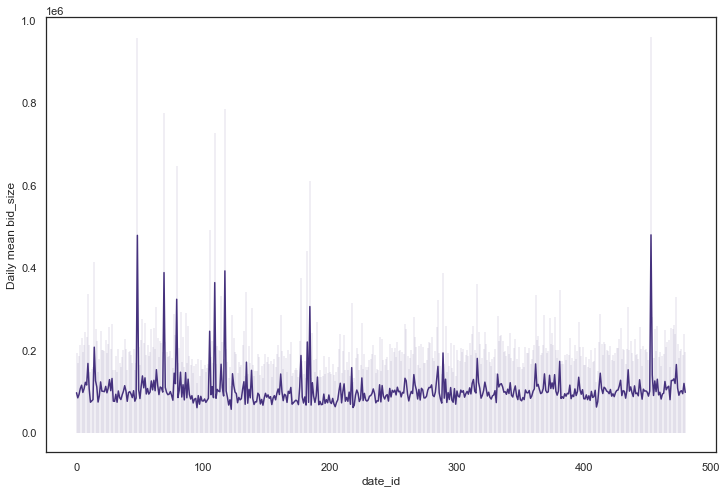

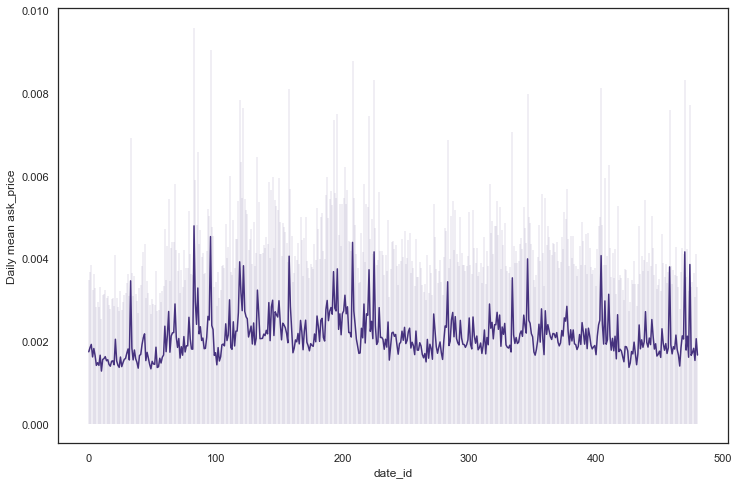

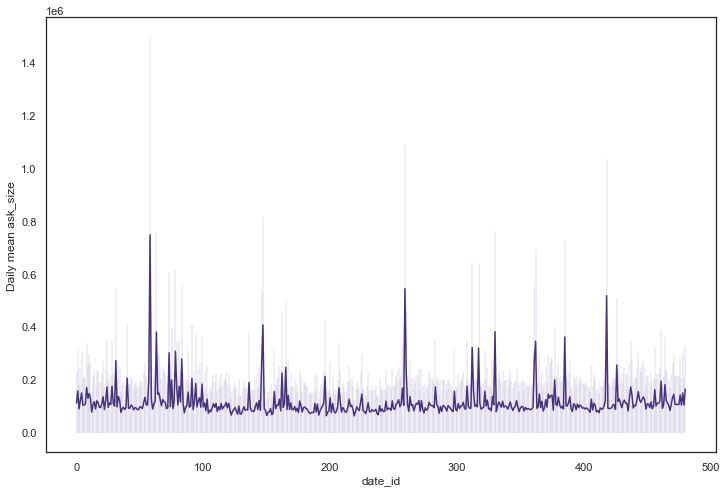

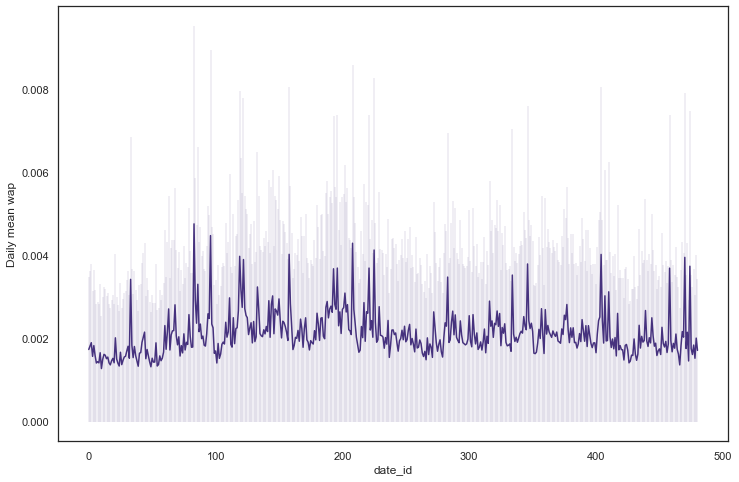

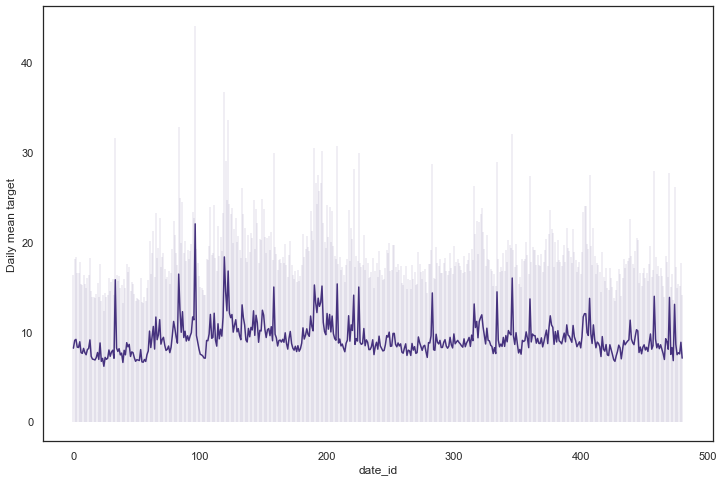

In [27]:
for feature in additional_features:
    plt.figure(figsize=(12,8))
    plt.plot(additional_features_dict[feature].keys(),additional_features_dict[feature].values())
    plt.xlabel('date_id')
    plt.ylabel(feature)


for feature in numerical_features:    
    plt.figure(figsize=(12,8))
    #plt.title('Feature: ' + feature + ' (each point is one date_id)')
    markers, caps, bars = plt.errorbar(num_feature_mean_dict[feature].keys(),num_feature_std_dict[feature].values(),yerr = num_feature_std_dict[feature].values(),alpha=0.1)
    markers.set_alpha(1)
    plt.xlabel('date_id')
    plt.ylabel('Daily mean ' + feature)
    plt.show()

Text(0.5, 0, 'Number of rows')

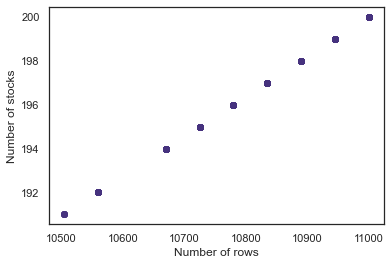

In [28]:
plt.scatter(additional_features_dict['number_of_rows'].values(),additional_features_dict['number_of_stocks'].values())
plt.ylabel("Number of stocks")
plt.xlabel('Number of rows')

### Comment #5:
For some features there are:
1) Outlier days
2) Volatile days
3) Baseline days

It could be useful to figure out why some days had such high jumps and to decide what to do with them.

# 3 Per stock analysis
I group the data by stock_id

In [29]:
number_of_rows = {}
number_of_dates = {}
num_feature_mean_dict = {}
num_feature_std_dict = {}
additional_features_dict = {}
additional_features = ['number_of_rows','number_of_dates']
numerical_features = ['imbalance_size', 'reference_price', 'matched_size', 'far_price',
       'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap','target']
for stock_id in train['stock_id'].unique():
    stock_df = train[train['stock_id'] ==stock_id ]
    number_of_rows[stock_id ] = len(stock_df)
    number_of_dates[stock_id ]  = len(stock_df['date_id'].unique())
    additional_features_dict['number_of_rows'] = number_of_rows
    additional_features_dict['number_of_dates'] = number_of_dates
for feature in numerical_features:
    print(feature)
    num_feature_mean_dict[feature] = {}
    num_feature_std_dict[feature] = {}
    for stock_id in train['stock_id'].unique():
        specific_df = train[train['stock_id'] == stock_id]
        num_feature_mean_dict[feature][stock_id] = specific_df[feature].mean()
        num_feature_std_dict[feature][stock_id] = specific_df[feature].std()

imbalance_size
reference_price
matched_size
far_price
near_price
bid_price
bid_size
ask_price
ask_size
wap
target


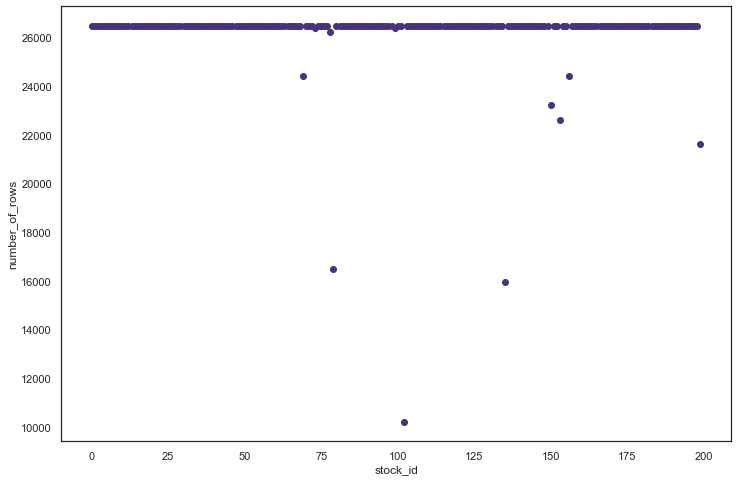

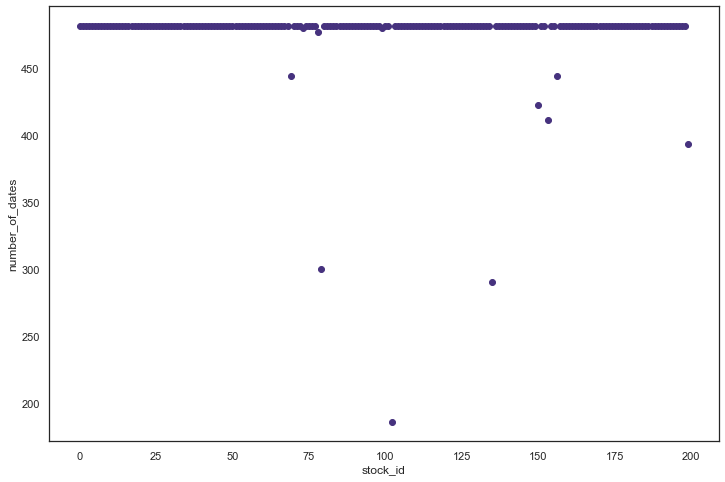

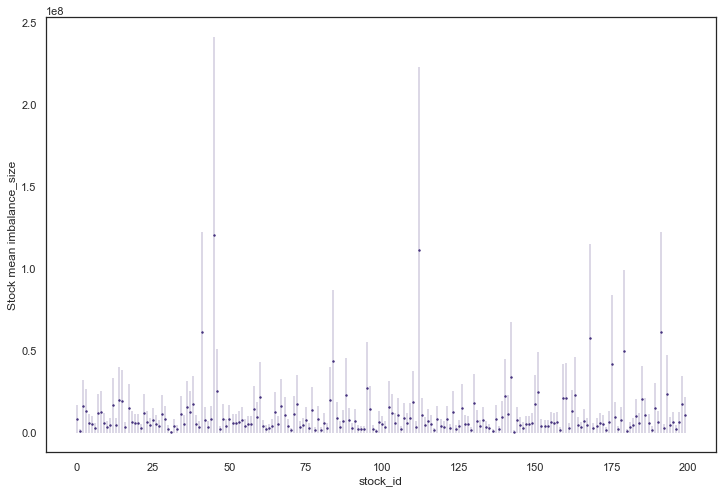

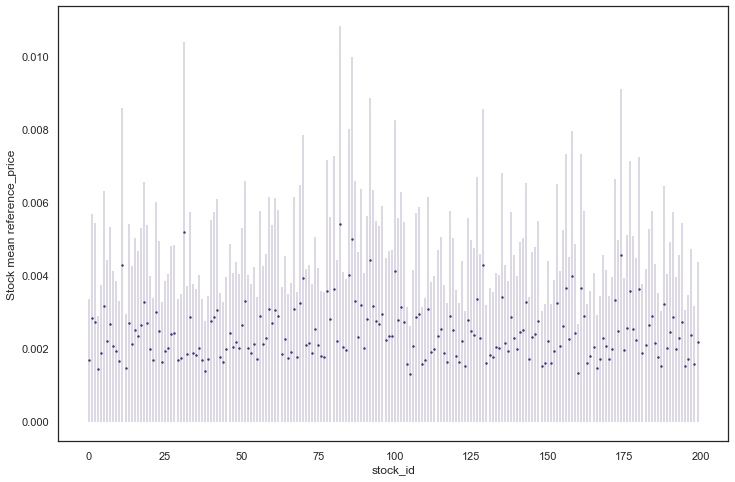

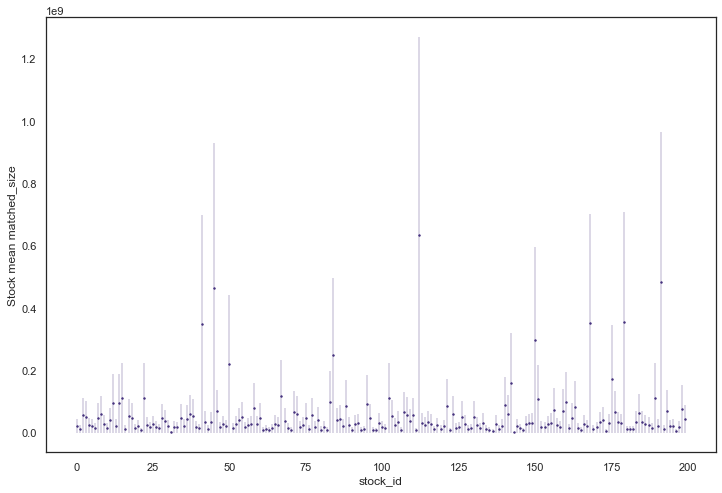

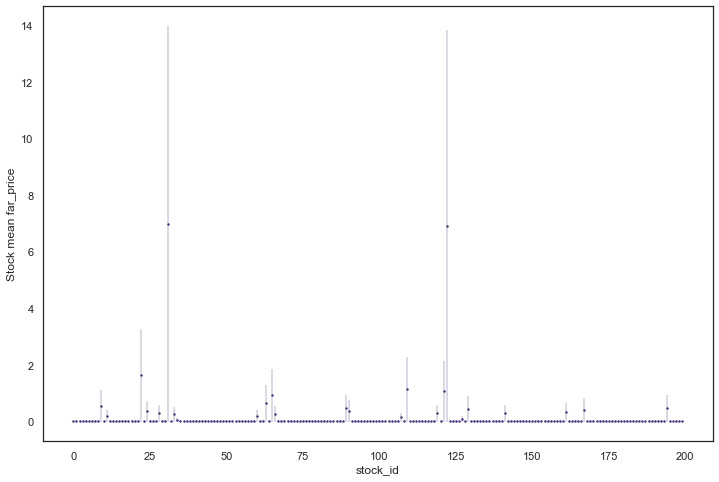

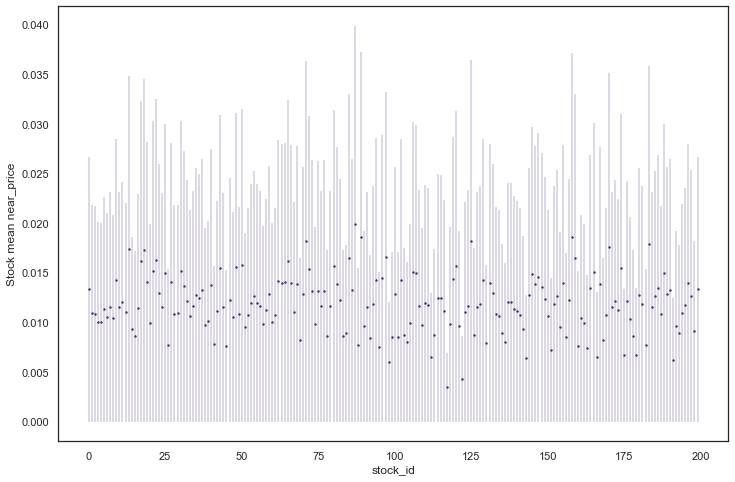

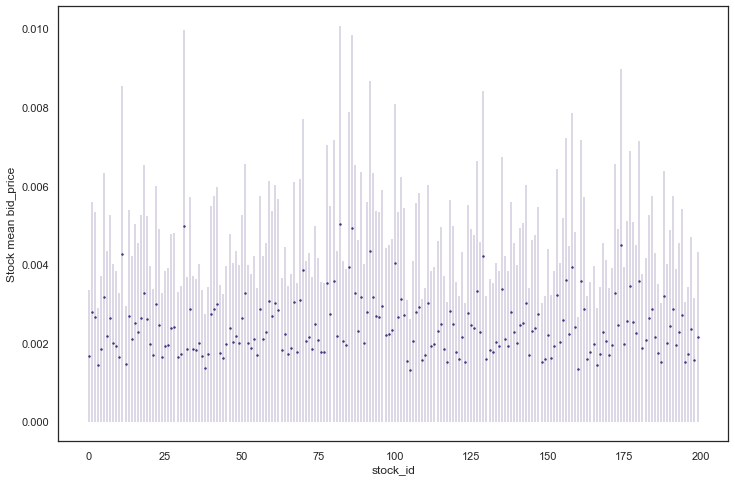

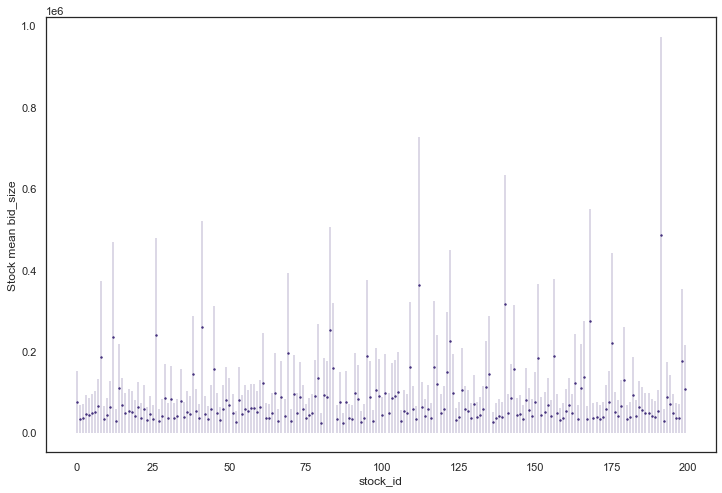

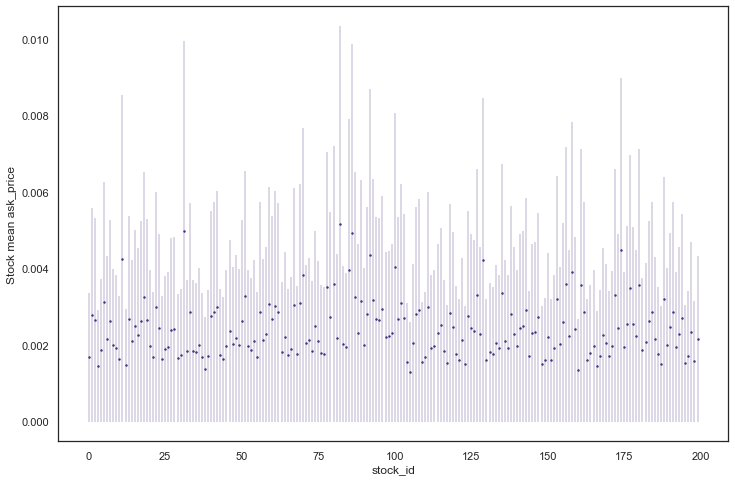

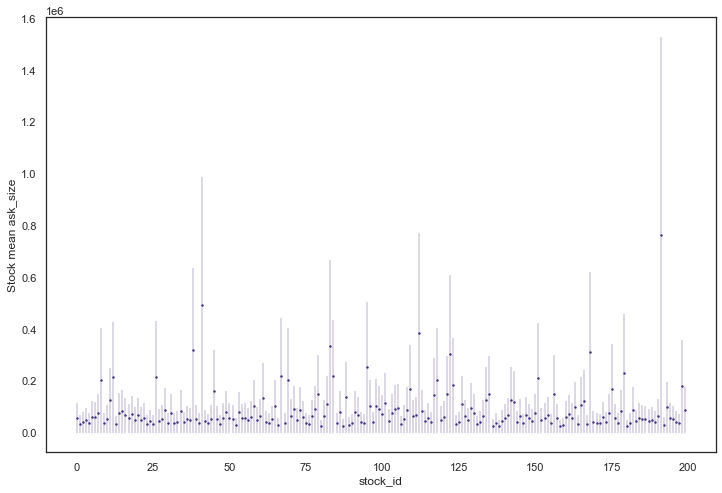

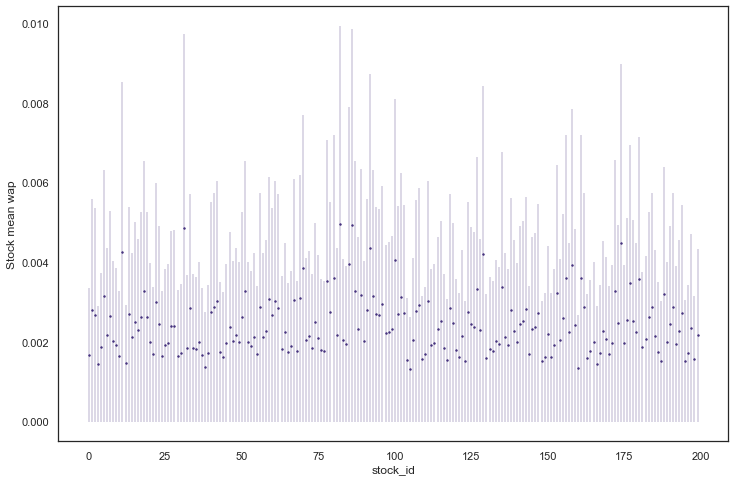

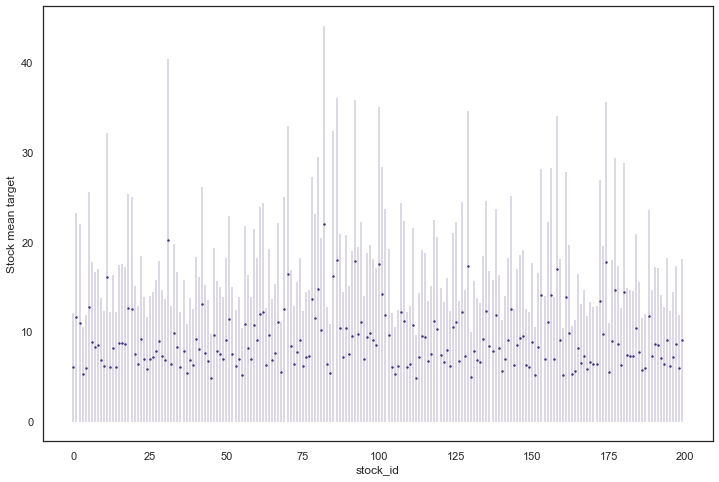

In [30]:
for feature in additional_features:
    plt.figure(figsize=(12,8))
    plt.scatter(additional_features_dict[feature].keys(),additional_features_dict[feature].values())
    plt.xlabel('stock_id')
    plt.ylabel(feature)


for feature in numerical_features:    
    plt.figure(figsize=(12,8))
    #plt.title('Feature: ' + feature + ' (each point is one date_id)')
    markers, caps, bars = plt.errorbar(num_feature_mean_dict[feature].keys(),num_feature_std_dict[feature].values(),
                                       yerr = num_feature_std_dict[feature].values(),alpha=0.25, linestyle='')
    plt.scatter(num_feature_mean_dict[feature].keys(),num_feature_std_dict[feature].values(),s=2)
    #markers.set_alpha(1)
    plt.xlabel('stock_id')
    plt.ylabel('Stock mean ' + feature)
    plt.show()

## Comment #6:
For some features there are:
1) Outlier stocks

2) Volatile stocks

3) Baseline stocks

It could be useful to figure out why some stocks had such high jumps and to decide what to do with them.

# 4. Test set 

In [31]:
test.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,26290
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,26290
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,26290
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,26290
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,26290
5,5,478,0,1150507.59,-1,0.999867,1580452.21,NaN,NaN,0.999722,10312.50,1.000449,16649.60,1.0,26290
6,6,478,0,57213.11,1,1.000361,3424296.94,NaN,NaN,0.999765,5535.45,1.000361,8492.75,1.0,26290
7,7,478,0,14786077.01,1,0.998998,54031419.37,NaN,NaN,0.998686,79933.75,1.000263,16012.00,1.0,26290
8,8,478,0,26157362.75,-1,0.999809,24384072.48,NaN,NaN,0.998885,10638.52,1.000279,2663.34,1.0,26290
9,9,478,0,426671.05,-1,1.000084,4467248.15,NaN,NaN,0.999952,755.00,1.000482,7554.00,1.0,26290


In [32]:
test.tail(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id
32990,190,480,540,466320.15,-1,0.999295,3.929472e+07,0.998983,0.999139,0.999295,19725.86,0.999451,169105.20,0.999311,26454
32991,191,480,540,36937785.44,1,0.995983,6.083261e+08,0.999086,0.997746,0.995913,84744.00,0.995983,48025.00,0.995958,26454
32992,192,480,540,67162.62,1,1.000762,1.179008e+07,1.000834,1.000762,1.000545,168412.86,1.000762,69841.50,1.000698,26454
32993,193,480,540,6500948.04,1,1.001599,8.035753e+07,1.002908,1.002326,1.001454,413142.24,1.001599,363532.53,1.001531,26454
32994,194,480,540,262271.52,-1,1.001504,3.922295e+06,1.000677,1.000677,1.001504,20829.20,1.001917,139637.49,1.001557,26454
32995,195,480,540,2440722.89,-1,1.000317,2.828036e+07,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454
32996,196,480,540,349510.47,-1,1.000643,9.187699e+06,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454
32997,197,480,540,0.00,0,0.995789,1.272544e+07,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454
32998,198,480,540,1000898.84,1,0.999210,9.477327e+07,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454
32999,199,480,540,1884285.71,-1,1.002129,2.407368e+07,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,26454


## Comment #7:
 It will cruical on how our test data is presented? Sequential? Just random snapshots of stocks and rows? Per day? Per stock?
 
 We also need to keep in mind the lookahead bias, since the real data won't have the date_id?
 
 